In [1]:
!pip install opendatasets

In [2]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from scipy import stats

import opendatasets as od

In [3]:
# Download Data

od.download("https://www.kaggle.com/competitions/home-credit-default-risk/data")

Skipping, found downloaded files in ".\home-credit-default-risk" (use force=True to force download)


## Load and view data

In [4]:
# Load Data
current_working_directory = os.getcwd()

test_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_test.csv")
train_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/application_train.csv")
previous_application_data = pd.read_csv(current_working_directory + "/home-credit-default-risk/previous_application.csv")

In [5]:
test_data.shape
#train_data.shape

(48744, 121)

Shapes:
> Train Data (307511, 122)

> Test Data  (48744, 121)



In [6]:
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

## Column Types

Note: *Categorical* variables (here 16) need to be encoded before models can be trained (later)

In [7]:
train_data.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Missing Values

In [8]:
train_data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [9]:
# Not all cols have missing values

m_val = pd.concat([train_data.isnull().sum(), 100 * train_data.isnull().sum() / len(train_data)], axis=1).rename(
  columns = {0 : 'No. missing', 1 : '% missing'})

m_val[m_val['No. missing'] != 0]

,No. missing,% missing
AMT_ANNUITY,12,0.003902
AMT_GOODS_PRICE,278,0.090403
NAME_TYPE_SUITE,1292,0.420148
OWN_CAR_AGE,202929,65.990810
OCCUPATION_TYPE,96391,31.345545
...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
AMT_REQ_CREDIT_BUREAU_MON,41519,13.501631
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.501631


67 rows have missing values. Need to do imputation.

## Checking if Target is balanced or imbalanced



In [10]:
train_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Target is unbalanced - can weight but not required

## Extremities

Look into int/float columns with personal info such as no. of days employed/ registration/ id publish/ age. Considered extreme if value indicates like 200 years or so.

2 ways: Describe suspicious columns OR plot a box plot

In [11]:
(train_data['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 1.0, 'Box Plot of Years Employed')

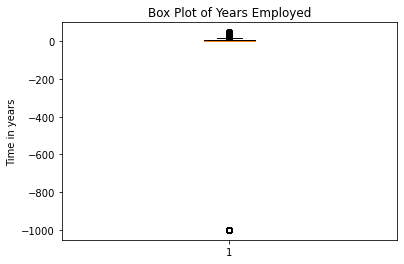

In [12]:
plt.boxplot(train_data['DAYS_EMPLOYED'] / -365)
plt.ylabel('Time in years')
plt.title('Box Plot of Years Employed')

What I see here, one extremity is that a person has been employed since 1000 years. 
Can replace with NaN (will get imputed later) or delete the row.

In [13]:
train_data = train_data[train_data['DAYS_EMPLOYED'] != 365243.000000]

'''
# OR to replace with NaN's

train_data = train_data.replace(train_data.loc[train_data['DAYS_EMPLOYED'] == 365243.000000] ,np.nan)
'''

"\n# OR to replace with NaN's\n\ntrain_data = train_data.replace(train_data.loc[train_data['DAYS_EMPLOYED'] == 365243.000000] ,np.nan)\n"

In [14]:
train_data.shape

(252137, 122)

## Correlations

Found between features and target. Can do in the form of heatmaps or any other plot. I tried with 2 features and target - age and days employed.



Text(0.5, 1.0, 'Correlation Heatmap')

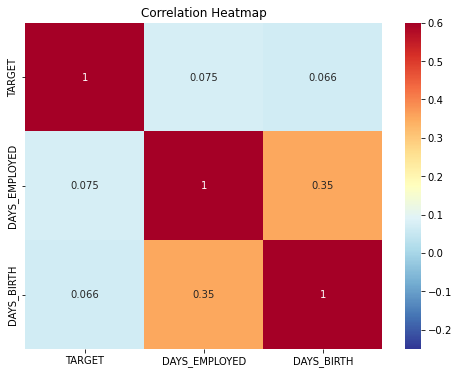

In [15]:
plt.figure(figsize = (8, 6))

sns.heatmap(train_data[['TARGET', 'DAYS_EMPLOYED', 'DAYS_BIRTH']].corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

## Encoding

Use label encoding for categorical values with 2 unique values

One hot for the rest (to avoid model assigning weights)

In [16]:
train_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# Label Encoding on ones with 2 unique vals
le = LabelEncoder()

for col in train_data:
  if train_data[col].dtype == 'object' and len(list(train_data[col].unique())) <= 2:
    le.fit(train_data[col])
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])


In [19]:
train_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
# Check again to see which columns are no longer in the list -> those have been encoded

CODE_GENDER                    3
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [20]:
# One Hot Encoding on the rest
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Train data', train_data.shape)
print('Test data', test_data.shape)

Train data (252137, 241)
Test data (48744, 239)


In [21]:
train_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
# Check again to see which columns are no longer in the list -> those have been encoded

Series([], dtype: float64)

## Check train-test sets alignment

Train and test sets must have the same columns. Above I see train has 242(excluding target) but test has 239). Happened during one-hot encoding. Removing the extra cols

In [22]:
temp = train_data['TARGET']
train_data, test_data = train_data.align(test_data, join = 'inner', axis = 1)
train_data['TARGET'] = temp

print('Train data', train_data.shape)
print('Test data', test_data.shape)

Train data (252137, 238)
Test data (48744, 237)


## Feature Engineering

Can create new features/ combine existing features.

doing missing value imputation. I'm doing it over median.

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)


In [24]:
train_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train_data.shape

(252137, 238)

In [26]:
train_data.isnull().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
                                  ..
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_No             0
EMERGENCYSTATE_MODE_Yes            0
TARGET                             0
Length: 238, dtype: int64

# Models

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Logistic Regression

In [28]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [30]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Predicting the probability cuz of submission file format on kaggle. If you want prediction, use "model.predict(X_test)" instead

C:\Users\garis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
accuracy_score(y_test, y_pred)

0.9133814547473625

## Random Forest

In [32]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [34]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
accuracy_score(y_test, y_pred)

0.9135797572777029

## Naive Bayes

In [36]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
accuracy_score(y_test, y_pred)

0.9075513603553581

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [40]:
model = GaussianNB()

In [41]:
scores = cross_val_score(model, X, y, cv=5)

In [42]:
print("Cross-Validation Scores:", scores)
print("Average Accuracy:", scores.mean())

Cross-Validation Scores: [0.91340129 0.90743238 0.90770817 0.90679596 0.90764868]
Average Accuracy: 0.9085972957595582


## Gradient Boosting

In [43]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
accuracy_score(y_test, y_pred)

0.9137582295550091

## SVM

In [36]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.svm import SVC
svm=SVC(C=0.0001, probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [38]:
accuracy_score(y_test, y_pred)

0.9134806060125327

### Data preparation. Describe any additional data preparation related to modeling: variable transformations, feature engineering, handling of NAs.
#### During the data preparation for modeling, I looked for missing values and opted to treat them by imputation. I then looked for extremes in the target variable's distribution and in the columns that contained personal data. I made a correlation heatmap to visualize feature-target relationships. Two unique values of categorical variables were encoded using label encoding, while the remaining values were encoded using one-hot encoding. By deleting excess columns added during one-hot encoding, I made sure that the train and test sets were aligned. The median technique was used to impute missing data after feature engineering. In order to ensure data balance, I lastly checked the distribution of the target variable.

### Modeling processList the candidate models you considered, the process for selecting the best model, cross-validation procedures, hyperparameter tuning.

#### Naive Bayes and Support Vector Machine (SVM) were two candidate models I looked at during the modeling process. I used the train_test_split function to divide the data into training and testing sets in order to choose the best model. I applied the GaussianNB implementation to Naive Bayes and trained the model using training data. In order to assess the model's performance, I then made predictions based on the test data and determined the accuracy score. Similar to how I did with SVM, I enabled probability estimates and used the SVC implementation with a specific value for the C parameter. I used the training data to train the SVM model, the test data for prediction, and the accuracy score calculation. The most effective model would be the one with the highest accuracy score.